####  Custom CNN Model (TensorFlow)

In this notebook I:

- Design a custom CNN with 3–4 convolutional blocks (+ BatchNorm, Dropout).
- Implement a `build_custom_cnn()` function.
- Compile the model with:
  - `binary_crossentropy` loss
  - Adam optimizer
  - metrics: accuracy, precision, recall
- Add a custom callback to compute F1-score on the validation set each epoch.
- Train the model using:
  - `train_ds_aug` (augmented training data)
  - `val_ds_norm` (normalized validation data)
- Save the best model as `models/tf_custom_cnn_best.h5` and plot training curves.


In [1]:
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

BASE_DIR = Path("../data/classification_dataset")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

print("Using dataset path:", BASE_DIR.resolve())


Using dataset path: D:\356 Data Science\PROJECT\LABMENTIX\Aerial Object Classification\data\classification_dataset


In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR / "train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR / "valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR / "test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode="binary"
)

class_names = train_ds.class_names
print("Class names:", class_names)

def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds_norm = (
    train_ds
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)

val_ds_norm = (
    val_ds
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

test_ds_norm = (
    test_ds
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)


Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.
Class names: ['bird', 'drone']


In [ ]:
# --- Augmentation layer  ---
def get_augmentation_layer(img_size=IMG_SIZE):
    height, width = img_size

    brightness_layer = layers.Lambda(
        lambda x: tf.clip_by_value(
            tf.image.random_brightness(x, max_delta=0.1),
            0.0, 1.0
        )
    )

    augmentation = tf.keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(
                height_factor=(-0.1, 0.1),
                width_factor=(-0.1, 0.1),
            ),
            brightness_layer,
            layers.RandomCrop(int(height * 0.9), int(width * 0.9)),
            layers.Resizing(height, width),
        ],
        name="data_augmentation",
    )
    return augmentation

data_augmentation = get_augmentation_layer()

def apply_augmentation(dataset, augmentation_layer, autotune=AUTOTUNE):
    return (
        dataset
        .map(lambda x, y: (augmentation_layer(x, training=True), y),
             num_parallel_calls=autotune)
        .prefetch(autotune)
    )

train_ds_aug = apply_augmentation(train_ds_norm, data_augmentation)
train_ds_aug


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

#### 1. Custom CNN Architecture

I define a CNN with:

- Input: `(224, 224, 3)`
- 4 convolutional blocks:
  - Conv2D → BatchNorm → ReLU → MaxPooling
- Fully-connected head:
  - Dense(256) + Dropout(0.5)
  - Output: Dense(1, activation='sigmoid') for binary classification

The function `build_custom_cnn()` returns an **uncompiled** Keras model.


In [4]:
def build_custom_cnn(input_shape=(224, 224, 3)) -> tf.keras.Model:
    inputs = layers.Input(shape=input_shape)

    x = inputs

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 4 (optional but useful)
    x = layers.Conv2D(256, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs, name="custom_cnn")
    return model

model = build_custom_cnn(input_shape=IMG_SIZE + (3,))
model.summary()


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,235,905 (50.49 MB)

 Trainable params: 13,234,945 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

#### 2. Metrics & F1-score Callback

Keras has built-in:

- `BinaryAccuracy`
- `Precision`
- `Recall`

But not F1 by default.  
I create a custom callback that:

- runs on each epoch end,
- predicts on the validation dataset,
- computes Precision, Recall, and F1 using `sklearn.metrics`,
- logs them and prints them.


In [6]:
class SklearnMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, threshold: float = 0.5):
        super().__init__()
        self.val_dataset = val_dataset
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        # collect all labels and predictions for the validation set
        y_true = []
        y_pred = []

        for batch_x, batch_y in self.val_dataset:
            preds = self.model.predict(batch_x, verbose=0)
            y_true.append(batch_y.numpy().ravel())
            y_pred.append((preds.ravel() >= self.threshold).astype(int))

        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        logs = logs or {}
        logs["val_precision_sklearn"] = precision
        logs["val_recall_sklearn"] = recall
        logs["val_f1_sklearn"] = f1

        print(
            f"\nEpoch {epoch+1}: "
            f"val_precision={precision:.4f}, "
            f"val_recall={recall:.4f}, "
            f"val_f1={f1:.4f}"
        )


In [7]:
model = build_custom_cnn(input_shape=IMG_SIZE + (3,))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

model.summary()


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,235,905 (50.49 MB)

 Trainable params: 13,234,945 (50.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

models_dir = Path("../models")
models_dir.mkdir(exist_ok=True)

checkpoint_path = models_dir / "tf_custom_cnn_best.h5"

callbacks = [
    ModelCheckpoint(
        filepath=str(checkpoint_path),
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1,
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1,
    ),
    SklearnMetricsCallback(val_ds_norm),
]


In [10]:
EPOCHS = 25

history = model.fit(
    train_ds_aug,
    validation_data=val_ds_norm,
    epochs=EPOCHS,
    callbacks=callbacks,
)


Epoch 1/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.8120 - loss: 0.4039 - precision: 0.8009 - recall: 0.7969
Epoch 1: val_accuracy did not improve from 0.80995

Epoch 1: val_precision=0.7235, val_recall=0.8489, val_f1=0.7812
84/84 ━━━━━━━━━━━━━━━━━━━━ 82s 967ms/step - accuracy: 0.8129 - loss: 0.4085 - precision: 0.8130 - recall: 0.7804 - val_accuracy: 0.7579 - val_loss: 0.5277 - val_precision: 0.7235 - val_recall: 0.8489 - val_precision_sklearn: 0.7235 - val_recall_sklearn: 0.8489 - val_f1_sklearn: 0.7812
Epoch 2/25
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.8191 - loss: 0.3913 - precision: 0.8274 - recall: 0.7827
Epoch 2: val_accuracy did not improve from 0.80995

Epoch 2: val_precision=0.8602, val_recall=0.7111, val_f1=0.7786
84/84 ━━━━━━━━━━━━━━━━━━━━ 83s 974ms/step - accuracy: 0.8208 - loss: 0.3970 - precision: 0.8270 - recall: 0.7812 - val_accuracy: 0.7941 - val_loss: 0.5260 - val_precision: 0.8602 - val_recall: 0.7111 - val_precision_sklearn: 0.8602 - va

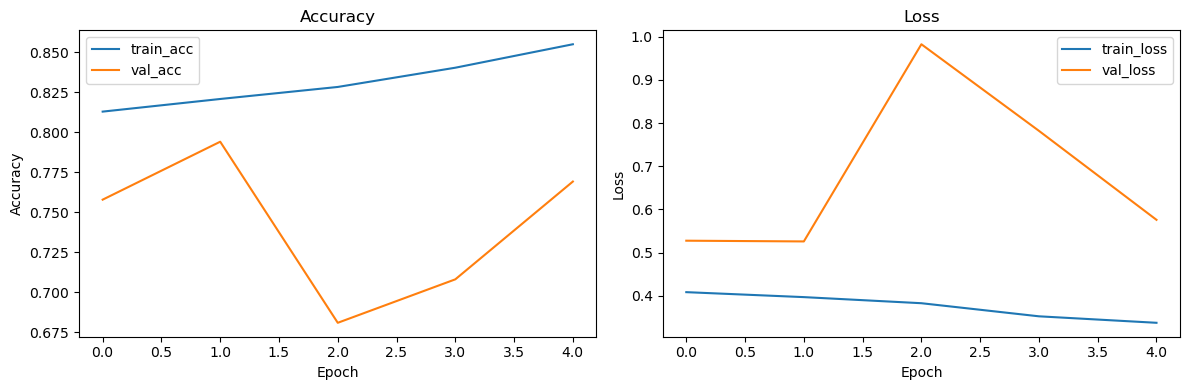

In [11]:
def plot_history(history):
    hist = history.history

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [18]:
test_metrics = model.evaluate(test_ds_norm, verbose=1)
print("Test metrics (loss, accuracy, precision, recall):", test_metrics)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8186 - loss: 0.3536 - precision: 0.7670 - recall: 0.8404    
Test metrics (loss, accuracy, precision, recall): [0.3535514175891876, 0.8186046481132507, 0.7669903039932251, 0.8404255509376526]
